In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import classification_report as report
from sklearn.preprocessing import StandardScaler
import pickle


### Graphs for Experiments

In [37]:
def build_obs(df, mapping):
    # take observed data and build targets of first 4 hours
    # Convert 'hour' to timedelta for proper grouping
    df["hour"] = df["hour"].sub(4)
    df['hour'] = pd.to_timedelta(df['hour'], unit='h')    
    # Group by time step and calculate the mean for each hour
    grouped = df.groupby(["ts_ind", pd.Grouper(key='hour', freq='1h')])[mapping].mean().reset_index()
    grouped["hour"] = grouped['hour'].dt.floor('H')
    grouped["hour"] = grouped.hour.astype(str).str.replace('0 days ', '')    
    # Create a complete set of expected hours
    expected_hours = pd.date_range(start='00:00:00', end='23:00:00', freq='1H').strftime('%H:%M:%S')

    # Create a DataFrame with all combinations of ts_ind and expected hours
    all_combinations = pd.DataFrame([(i, h) for i in grouped['ts_ind'].unique() for h in expected_hours], columns=['ts_ind', 'hour'])
    # Merge the calculated means with the DataFrame of all combinations
    grouped_filled = pd.merge(all_combinations, grouped, on=['ts_ind', 'hour'], how='left')

    return grouped_filled

def restore_predictions(predictions, mapping):
    # bring STraTS predicions in format for MSE
    l = []
    leng = len(predictions.iloc[0]) / len(mapping)
    for i in range(len(predictions)):
        arr = np.asarray(predictions.iloc[i]).reshape((int(leng),len(mapping)))
        l.append(arr)
    df = pd.concat([pd.DataFrame(arr) for arr in l])#, keys=np.arange(len(l)))
    
    df.columns=mapping
    return df

def mse_loss_with_nans(prediction, target, ax):

    # Mask missing values in target observations
    mask = pd.isna(target)

    # mean of the squared error along axis. 
    # axis 1 is column wise e.g. for each feature
    # axis 0 is row wise e.g. to get mse per timestep
    mse = np.mean((target[~mask]-prediction[~mask])**2, axis=ax)
    #mse = np.sum((target[~mask]-prediction)**2, axis=ax)


    return mse

### load data here for graph EXP1

/Users/pablo/.conda/envs/microsoft_sepsis/lib/python3.9/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/pablo/.conda/envs/microsoft_sepsis/lib/python3.9/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


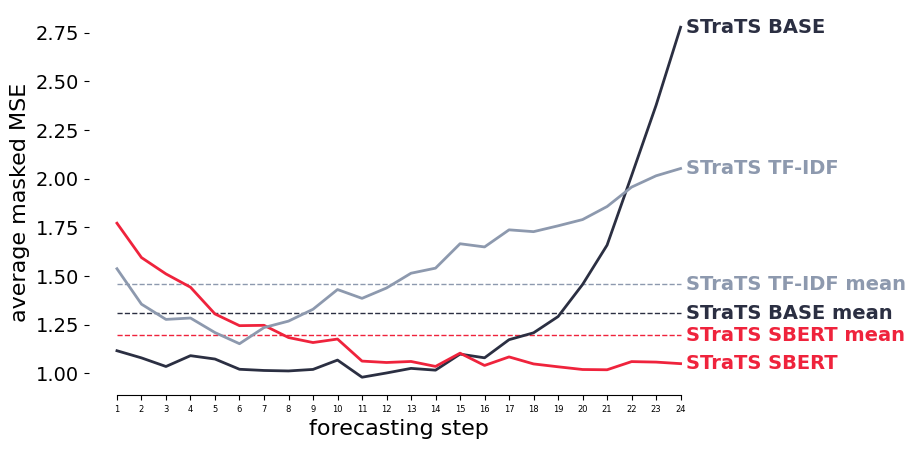

In [38]:
##EXP 1
with open("idfix_Unseeded4_notext_st_fo_targets_dump.pkl", "rb") as pfile:
    notext_st, notext_fo, notext_observe_targets, notext_var_map = pickle.load(pfile)
with open("idfix_Unseeded4_sb_st_fo_targets_dump.pkl", "rb") as pfile:
    sb_st, sb_fo, sb_observe_targets, sb_var_map = pickle.load(pfile)
with open("idfix_Unseeded4_tf_st_fo_targets_dump.pkl", "rb") as pfile:
    tf_st, tf_fo, tf_observe_targets, tf_var_map = pickle.load(pfile)
with open("idfix_Unseeded4_noise_st_fo_targets_dump.pkl", "rb") as pfile:
    noise_st, noise_fo, noise_observe_targets, noise_var_map = pickle.load(pfile)


## ONLY LAB FEATURES, ALL MODELS, DISREGARD TFID AND BERT, TO SEE HOW THEY HELPED LAB FEATURE FORECASTING
only_lab_notext_fore = notext_fo
only_lab_notext_target = notext_observe_targets
only_lab_sb = sb_fo[notext_fo.columns]
only_lab_sb_target = sb_observe_targets[notext_fo.columns]
only_lab_tf = tf_fo[notext_fo.columns]
only_lab_tf_target = tf_observe_targets[notext_fo.columns]
only_lab_noise_fore = noise_fo
only_lab_noise_target = noise_observe_targets

only_lab_sb_target = notext_observe_targets
only_lab_tf_target = notext_observe_targets
only_lab_noise_target = notext_observe_targets

tf_step = list(range(1,25,1)) * int((len(only_lab_notext_fore) / 24))
only_notext_st = pd.DataFrame(tf_step, columns=["step"])
only_tf_st = pd.DataFrame(tf_step, columns=["step"])
only_sb_st = pd.DataFrame(tf_step, columns=["step"])
only_noise_st = pd.DataFrame(tf_step, columns=["step"])


only_notext_st = only_notext_st.reset_index().drop(columns="index")
only_sb_st = only_sb_st.reset_index().drop(columns="index")
only_tf_st = only_tf_st.reset_index().drop(columns="index")
only_noise_st = only_noise_st.reset_index().drop(columns="index")


## Stepwise MSE: 
#compute MSE for each step of each patient -> sum of one row / #features = MSE at step x for one patient. 
only_notext_st["mse"] = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 1)
only_sb_st["mse"] = mse_loss_with_nans(only_lab_sb, only_lab_notext_target, 1)
only_tf_st["mse"] = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, 1)
only_noise_st["mse"] = mse_loss_with_nans(only_lab_noise_fore,only_lab_notext_target, 1)


## Stepwise MSE, Averaged over all patients -> (all feature errors of all patients at step x).mean()  
only_notext_step_wise_mse_mean_1 = only_notext_st.groupby("step").mean()
only_sb_step_wise_mse_mean_1 = only_sb_st.groupby("step").mean()
only_tf_step_wise_mse_mean_1 = only_tf_st.groupby("step").mean()
only_noise_step_wise_mse_mean_1 = only_noise_st.groupby("step").mean()


notext_mean_1 = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, None)
sb_mean_1 = mse_loss_with_nans(only_lab_sb,only_lab_notext_target, None)
tf_mean_1 = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, None)
noise_mean_1 = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, None)


x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
labels = ['STraTS BASE','STraTS SBERT', 'STraTS TF-IDF']
#labels = ['STraTS BASE', 'STraTS SBERT','STraTS NOISE']
fig, ax = plt.subplots(
    figsize=(8, 5)
)

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=5)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean_1, notext_mean_1],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean_1,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean_1, sb_mean_1],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean_1,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean_1, tf_mean_1],
    label="STraTS TF-IDF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean_1,
    "STraTS TF-IDF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE"]
for frame in [only_notext_step_wise_mse_mean_1, only_sb_step_wise_mse_mean_1, only_tf_step_wise_mse_mean_1]:
    ax.plot(x, frame, color=colors[i], label=labels[i], linewidth=2)
    ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
   
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("forecasting step")
ax.set_ylabel("average masked MSE")
ax.tick_params(axis='x', labelsize=6)
plt.savefig("EXP1_stepwiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()


### load data here for graph EXP2

/Users/pablo/.conda/envs/microsoft_sepsis/lib/python3.9/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/pablo/.conda/envs/microsoft_sepsis/lib/python3.9/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


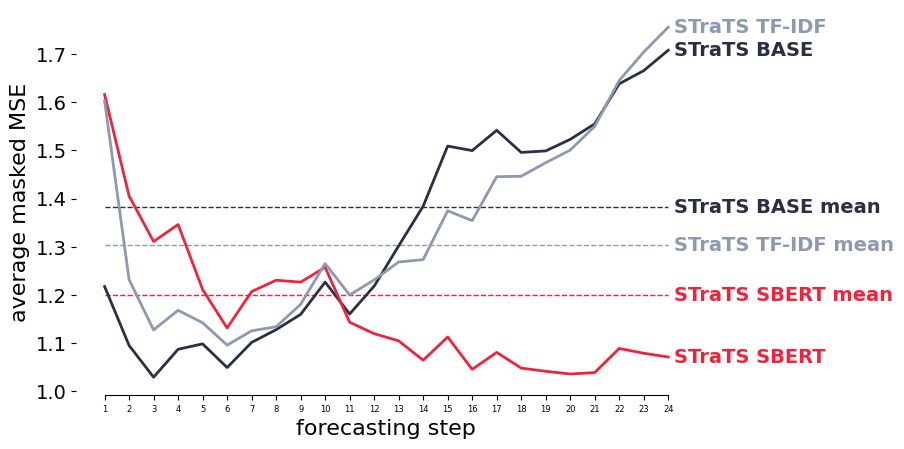

In [39]:
##EXP 2
with open("idfix_Unseeded5_notext_st_fo_targets_dump.pkl", "rb") as pfile:
    notext_st, notext_fo, notext_observe_targets, notext_var_map = pickle.load(pfile)
with open("idfix_Unseeded5_sb_st_fo_targets_dump.pkl", "rb") as pfile:
    sb_st, sb_fo, sb_observe_targets, sb_var_map = pickle.load(pfile)
with open("idfix_Unseeded5_tf_st_fo_targets_dump.pkl", "rb") as pfile:
    tf_st, tf_fo, tf_observe_targets, tf_var_map = pickle.load(pfile)
with open("idfix_Unseeded5_noise_st_fo_targets_dump.pkl", "rb") as pfile:
    noise_st, noise_fo, noise_observe_targets, noise_var_map = pickle.load(pfile)

## ONLY LAB FEATURES, ALL MODELS, DISREGARD TFID AND BERT, TO SEE HOW THEY HELPED LAB FEATURE FORECASTING
only_lab_notext_fore = notext_fo
only_lab_notext_target = notext_observe_targets
only_lab_sb = sb_fo[notext_fo.columns]
only_lab_sb_target = sb_observe_targets[notext_fo.columns]
only_lab_tf = tf_fo[notext_fo.columns]
only_lab_tf_target = tf_observe_targets[notext_fo.columns]
only_lab_noise_fore = noise_fo
only_lab_noise_target = notext_observe_targets

only_lab_sb_target = notext_observe_targets
only_lab_tf_target = notext_observe_targets

tf_step = list(range(1,25,1)) * int((len(only_lab_notext_fore) / 24))
only_notext_st = pd.DataFrame(tf_step, columns=["step"])
only_tf_st = pd.DataFrame(tf_step, columns=["step"])
only_sb_st = pd.DataFrame(tf_step, columns=["step"])
only_noise_st = pd.DataFrame(tf_step, columns=["step"])


only_notext_st = only_notext_st.reset_index().drop(columns="index")
only_sb_st = only_sb_st.reset_index().drop(columns="index")
only_tf_st = only_tf_st.reset_index().drop(columns="index")
only_noise_st = only_noise_st.reset_index().drop(columns="index")


## Stepwise MSE: 
#compute MSE for each step of each patient -> sum of one row / #features = MSE at step x for one patient. 
only_notext_st["mse"] = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 1)
only_sb_st["mse"] = mse_loss_with_nans(only_lab_sb, only_lab_notext_target, 1)
only_tf_st["mse"] = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, 1)
only_noise_st["mse"] = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, 1)


## Stepwise MSE, Averaged over all patients -> (all feature errors of all patients at step x).mean()  
only_notext_step_wise_mse_mean_2 = only_notext_st.groupby("step").mean()
only_sb_step_wise_mse_mean_2 = only_sb_st.groupby("step").mean()
only_tf_step_wise_mse_mean_2 = only_tf_st.groupby("step").mean()
only_noise_step_wise_mse_mean_2 = only_noise_st.groupby("step").mean()


notext_mean_2 = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, None)
sb_mean_2 = mse_loss_with_nans(only_lab_sb,only_lab_notext_target, None)
tf_mean_2 = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, None)
noise_mean_2 = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, None)


x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
labels = ['STraTS BASE','STraTS SBERT', 'STraTS TF-IDF']
#labels = ['STraTS BASE', 'STraTS SBERT','STraTS NOISE']
fig, ax = plt.subplots(
    figsize=(8, 5)
)

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=5)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean_2, notext_mean_2],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean_2,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean_2, sb_mean_2],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean_2,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean_2, tf_mean_2],
    label="STraTS TF-IDF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean_2,
    "STraTS TF-IDF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE"]
for frame in [only_notext_step_wise_mse_mean_2, only_sb_step_wise_mse_mean_2, only_tf_step_wise_mse_mean_2]:
    ax.plot(x, frame, color=colors[i], label=labels[i], linewidth=2)
    ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
   
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("forecasting step")
ax.set_ylabel("average masked MSE")
ax.tick_params(axis='x', labelsize=6)
plt.savefig("EXP2_stepwiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()


### load data here for graph EXP3

/Users/pablo/.conda/envs/microsoft_sepsis/lib/python3.9/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/pablo/.conda/envs/microsoft_sepsis/lib/python3.9/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


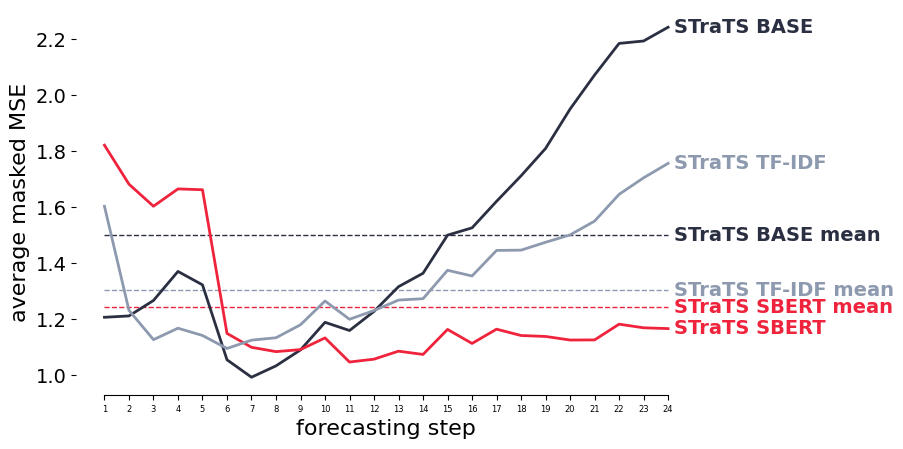

In [40]:
##EXP 3
with open("idfix_Unseeded6_notext_st_fo_targets_dump.pkl", "rb") as pfile:
    notext_st, notext_fo, notext_observe_targets, notext_var_map = pickle.load(pfile)
with open("idfix_Unseeded6_sb_st_fo_targets_dump.pkl", "rb") as pfile:
    sb_st, sb_fo, sb_observe_targets, sb_var_map = pickle.load(pfile)
with open("idfix_Unseeded6_tf_st_fo_targets_dump.pkl", "rb") as pfile:
    tf_st, tf_fo, tf_observe_targets, tf_var_map = pickle.load(pfile)
with open("idfix_Unseeded6_noise_st_fo_targets_dump.pkl", "rb") as pfile:
    noise_st, noise_fo, noise_observe_targets, noise_var_map = pickle.load(pfile)

## ONLY LAB FEATURES, ALL MODELS, DISREGARD TFID AND BERT, TO SEE HOW THEY HELPED LAB FEATURE FORECASTING
only_lab_notext_fore = notext_fo
only_lab_notext_target = notext_observe_targets
only_lab_sb = sb_fo[notext_fo.columns]
only_lab_sb_target = sb_observe_targets[notext_fo.columns]
only_lab_tf = tf_fo[notext_fo.columns]
only_lab_tf_target = tf_observe_targets[notext_fo.columns]
only_lab_noise_fore = noise_fo
only_lab_noise_target = notext_observe_targets

only_lab_sb_target = notext_observe_targets
only_lab_tf_target = notext_observe_targets

tf_step = list(range(1,25,1)) * int((len(only_lab_notext_fore) / 24))
only_notext_st = pd.DataFrame(tf_step, columns=["step"])
only_tf_st = pd.DataFrame(tf_step, columns=["step"])
only_sb_st = pd.DataFrame(tf_step, columns=["step"])
only_noise_st = pd.DataFrame(tf_step, columns=["step"])


only_notext_st = only_notext_st.reset_index().drop(columns="index")
only_sb_st = only_sb_st.reset_index().drop(columns="index")
only_tf_st = only_tf_st.reset_index().drop(columns="index")
only_noise_st = only_noise_st.reset_index().drop(columns="index")


## Stepwise MSE: 
#compute MSE for each step of each patient -> sum of one row / #features = MSE at step x for one patient. 
only_notext_st["mse"] = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 1)
only_sb_st["mse"] = mse_loss_with_nans(only_lab_sb, only_lab_notext_target, 1)
only_tf_st["mse"] = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, 1)
only_noise_st["mse"] = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, 1)


## Stepwise MSE, Averaged over all patients -> (all feature errors of all patients at step x).mean()  
only_notext_step_wise_mse_mean_3 = only_notext_st.groupby("step").mean()
only_sb_step_wise_mse_mean_3 = only_sb_st.groupby("step").mean()
only_tf_step_wise_mse_mean_3 = only_tf_st.groupby("step").mean()
only_noise_step_wise_mse_mean_3 = only_noise_st.groupby("step").mean()


notext_mean_3 = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, None)
sb_mean_3 = mse_loss_with_nans(only_lab_sb,only_lab_notext_target, None)
tf_mean_3 = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, None)
noise_mean_3 = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, None)


x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
labels = ['STraTS BASE','STraTS SBERT', 'STraTS TF-IDF']
#labels = ['STraTS BASE', 'STraTS SBERT','STraTS NOISE']
fig, ax = plt.subplots(
    figsize=(8, 5)
)

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=5)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean_3, notext_mean_3],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean_3,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean_3, sb_mean_3],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean_3,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean_3, tf_mean_3],
    label="STraTS TF-IDF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean_3,
    "STraTS TF-IDF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE"]
for frame in [only_notext_step_wise_mse_mean_3, only_sb_step_wise_mse_mean_3, only_tf_step_wise_mse_mean_3]:
    ax.plot(x, frame, color=colors[i], label=labels[i], linewidth=2)
    ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
   
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("forecasting step")
ax.set_ylabel("average masked MSE")
ax.tick_params(axis='x', labelsize=6)
plt.savefig("EXP3_stepwiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()


### graph AVG

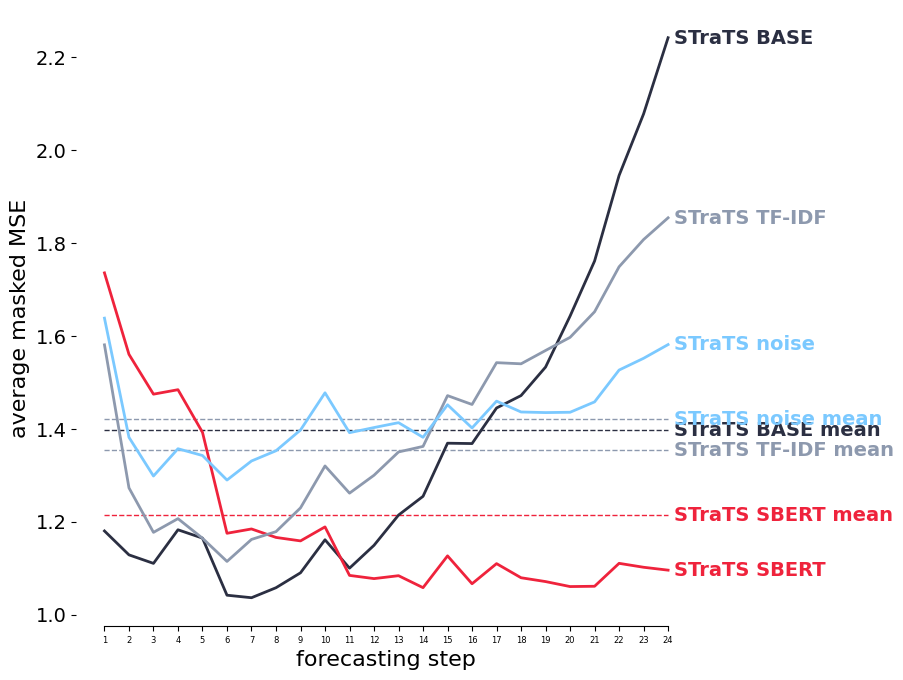

BASE avg mean: 1.3965643826711964
SBERT avg mean: 1.2137970181110938
TF-IDF avg mean: 1.3539717760260783
noise avg mean: 1.421337057784922


In [44]:
## Stepwise MSE, Averaged over all patients and all models -> (all feature errors of all patients at step x).mean()  
only_notext_step_wise_mse_mean_avg = (only_notext_step_wise_mse_mean_1 + only_notext_step_wise_mse_mean_2 + only_notext_step_wise_mse_mean_3) / 3
only_sb_step_wise_mse_mean_avg = (only_sb_step_wise_mse_mean_1 + only_sb_step_wise_mse_mean_2 + only_sb_step_wise_mse_mean_3) / 3
only_tf_step_wise_mse_mean_avg = (only_tf_step_wise_mse_mean_1 + only_tf_step_wise_mse_mean_2 + only_tf_step_wise_mse_mean_3) / 3
only_noise_step_wise_mse_mean_avg = (only_noise_step_wise_mse_mean_1 + only_noise_step_wise_mse_mean_2 + only_noise_step_wise_mse_mean_3) / 3


notext_mean_avg = (notext_mean_1 + notext_mean_2 + notext_mean_3) / 3 
sb_mean_avg = (sb_mean_1 + sb_mean_2 + sb_mean_3) / 3
tf_mean_avg = (tf_mean_1 + tf_mean_2 + tf_mean_3) / 3
noise_mean_avg = (noise_mean_1 + noise_mean_2 + noise_mean_3) / 3 


x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
labels = ['STraTS BASE','STraTS SBERT', 'STraTS TF-IDF', 'STraTS noise']
#labels = ['STraTS BASE', 'STraTS SBERT','STraTS NOISE']
fig, ax = plt.subplots(
    figsize=(8, 8)
)

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=5)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean_avg, notext_mean_avg],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean_avg,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean_avg, sb_mean_avg],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean_avg,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean_avg, tf_mean_avg],
    label="STraTS TF-IDF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean_avg,
    "STraTS TF-IDF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [noise_mean_avg, noise_mean_avg],
    label="STraTS noise mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    noise_mean_avg,
    "STraTS noise mean",
    color="#7BC9FF",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE", "#7BC9FF"]
for frame in [only_notext_step_wise_mse_mean_avg, only_sb_step_wise_mse_mean_avg, only_tf_step_wise_mse_mean_avg, only_noise_step_wise_mse_mean_avg]:
    ax.plot(x, frame, color=colors[i], label=labels[i], linewidth=2)
    ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
   
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("forecasting step")
ax.set_ylabel("average masked MSE")
ax.tick_params(axis='x', labelsize=6)
plt.savefig("EXPAVG_stepwiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()

print("BASE avg mean:", notext_mean_avg)
print("SBERT avg mean:", sb_mean_avg)
print("TF-IDF avg mean:", tf_mean_avg)
print("noise avg mean:", noise_mean_avg)

In [20]:
## ONLY LAB FEATURES, ALL MODELS, DISREGARD TFID AND BERT, TO SEE HOW THEY HELPED LAB FEATURE FORECASTING
only_lab_notext_fore = notext_fo
only_lab_notext_target = notext_observe_targets
only_lab_sb = sb_fo[notext_fo.columns]
only_lab_sb_target = sb_observe_targets[notext_fo.columns]
only_lab_tf = tf_fo[notext_fo.columns]
only_lab_tf_target = tf_observe_targets[notext_fo.columns]

only_lab_sb_target = notext_observe_targets
only_lab_tf_target = notext_observe_targets

tf_step = list(range(1,25,1)) * int((len(only_lab_notext_fore) / 24))
only_notext_st = pd.DataFrame(tf_step, columns=["step"])
only_tf_st = pd.DataFrame(tf_step, columns=["step"])
only_sb_st = pd.DataFrame(tf_step, columns=["step"])

only_notext_st = only_notext_st.reset_index().drop(columns="index")
only_sb_st = only_sb_st.reset_index().drop(columns="index")
only_tf_st = only_tf_st.reset_index().drop(columns="index")

## Stepwise MSE: 
#compute MSE for each step of each patient -> sum of one row / #features = MSE at step x for one patient. 
only_notext_st["mse"] = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 1)
only_sb_st["mse"] = mse_loss_with_nans(only_lab_sb, only_lab_notext_target, 1)
only_tf_st["mse"] = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, 1)

## Stepwise MSE, Averaged over all patients -> (all feature errors of all patients at step x).mean()  
only_notext_step_wise_mse_mean = only_notext_st.groupby("step").mean()
only_sb_step_wise_mse_mean = only_sb_st.groupby("step").mean()
only_tf_step_wise_mse_mean = only_tf_st.groupby("step").mean()

notext_mean = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, None)
sb_mean = mse_loss_with_nans(only_lab_sb,only_lab_notext_target, None)
tf_mean = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, None)

x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
labels = ['STraTS BASE','STraTS SBERT', 'STraTS TF-IDF']
#labels = ['STraTS BASE', 'STraTS SBERT','STraTS NOISE']
fig, ax = plt.subplots(
    figsize=(8, 5)
)

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=5)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean, notext_mean],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean, sb_mean],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean, tf_mean],
    label="STraTS TF-IDF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean,
    "STraTS TF-IDF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE"]
for frame in [only_notext_step_wise_mse_mean, only_sb_step_wise_mse_mean, only_tf_step_wise_mse_mean]:
    ax.plot(x, frame, color=colors[i], label=labels[i], linewidth=2)
    ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
   
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("forecasting step")
ax.set_ylabel("average masked MSE")
ax.tick_params(axis='x', labelsize=6)
plt.savefig("EXP2_stepwiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()


KeyboardInterrupt: 

In [53]:
m = only_notext_st["mse"].isna()
print(m.value_counts())
only_lab_notext_target[m].isna().value_counts()
(174017+2335) / 24


mse
False    174017
True       2335
Name: count, dtype: int64


7348.0

In [8]:
#print(only_lab_notext_target)
#print(only_lab_sb_target)
print("sanity check ids, sollte empty sein",only_lab_notext_target.compare(only_lab_sb_target))
#print(only_lab_tf_target.compare(only_lab_sb_target))

sanity check ids, sollte empty sein Empty DataFrame
Columns: []
Index: []


In [18]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(3)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

lab_missing = missing_values_table(notext_observe_targets)
text_missing = missing_values_table(sb_observe_targets)

Your selected dataframe has 133 columns.
There are 133 columns that have missing values.
Your selected dataframe has 183 columns.
There are 183 columns that have missing values.


In [19]:
print(lab_missing["% of Total Values"].mean())
print(text_missing["% of Total Values"].mean())

89.79281954887217
88.30653005464481


In [13]:
for i in range(len(lab_missing)):
    print(i, lab_missing.iloc[i])

0 Missing Values       176339.000
% of Total Values        99.993
Name: Lymphocytes (Absolute), dtype: float64
1 Missing Values       176299.00
% of Total Values        99.97
Name: Insulin NPH, dtype: float64
2 Missing Values       176210.000
% of Total Values        99.919
Name: Levofloxacin, dtype: float64
3 Missing Values       176195.000
% of Total Values        99.911
Name: Residual, dtype: float64
4 Missing Values       176107.000
% of Total Values        99.861
Name: Free Water, dtype: float64
5 Missing Values       176092.000
% of Total Values        99.853
Name: Ultrafiltrate, dtype: float64
6 Missing Values       176085.000
% of Total Values        99.849
Name: Bilirubin (Indirect), dtype: float64
7 Missing Values       176068.000
% of Total Values        99.839
Name: Albumin 25%, dtype: float64
8 Missing Values       176059.000
% of Total Values        99.834
Name: Bilirubin (Direct), dtype: float64
9 Missing Values       175985.000
% of Total Values        99.792
Name: Pre-

Your selected dataframe has 133 columns.
There are 133 columns that have missing values.


findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not

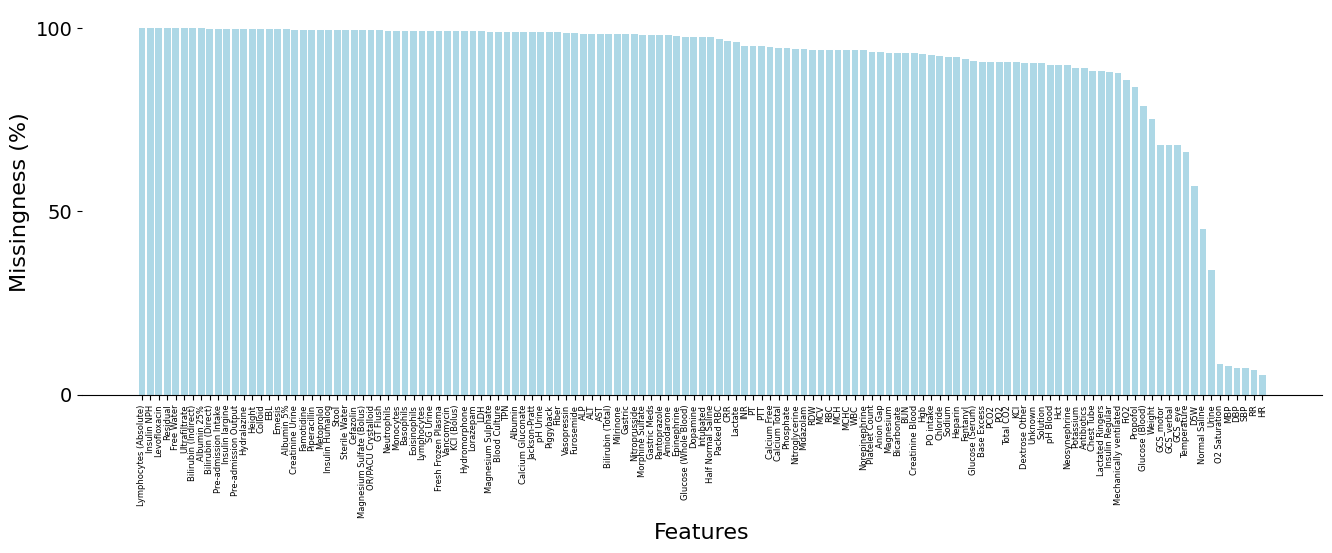

In [81]:


fig, ax = plt.subplots(
    figsize=(16, 5)
)

# Define font sizes
SIZE_SMALL = 6
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_SMALL)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

x = range(0,101)
ax.bar(lab_missing.index, lab_missing["% of Total Values"].values, color="lightblue", linewidth=1)
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
#ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_yticks([0,50,100])
ax.set_xlabel("Features")
ax.set_ylabel("Missingness (%)")
plt.xticks(rotation=90)
#plt.xlim(0,18000)
#plt.ylim(0,30)
#plt.title("Average MSE from forecasting step 1 to 24")
#plt.xlabel("forecasting step")
#plt.ylabel("Average of MSE (over testset)")
#ax.legend()
plt.savefig("testsetMISSINGNESS.png", dpi=300,bbox_inches = 'tight')
plt.show()


In [132]:
mse_loss_with_nans(only_lab_tf, only_lab_notext_target, 0).mean()

1.20593091889254

findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.


ALP            0.886873
ALT            1.663508
AST            1.563828
Albumin        1.089124
Albumin 25%     2.88375
                 ...   
Vasopressin    0.696841
WBC            3.386619
Weight         1.058697
pH Blood         1.0815
pH Urine       1.390385
Length: 133, dtype: object
Average MSE of Lab Features
wenn notext höher ist perfekt, wenn nicht fraglich wieso
notext    1.599566
sBert     1.260956
tfidf     1.205931
dtype: object


findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not

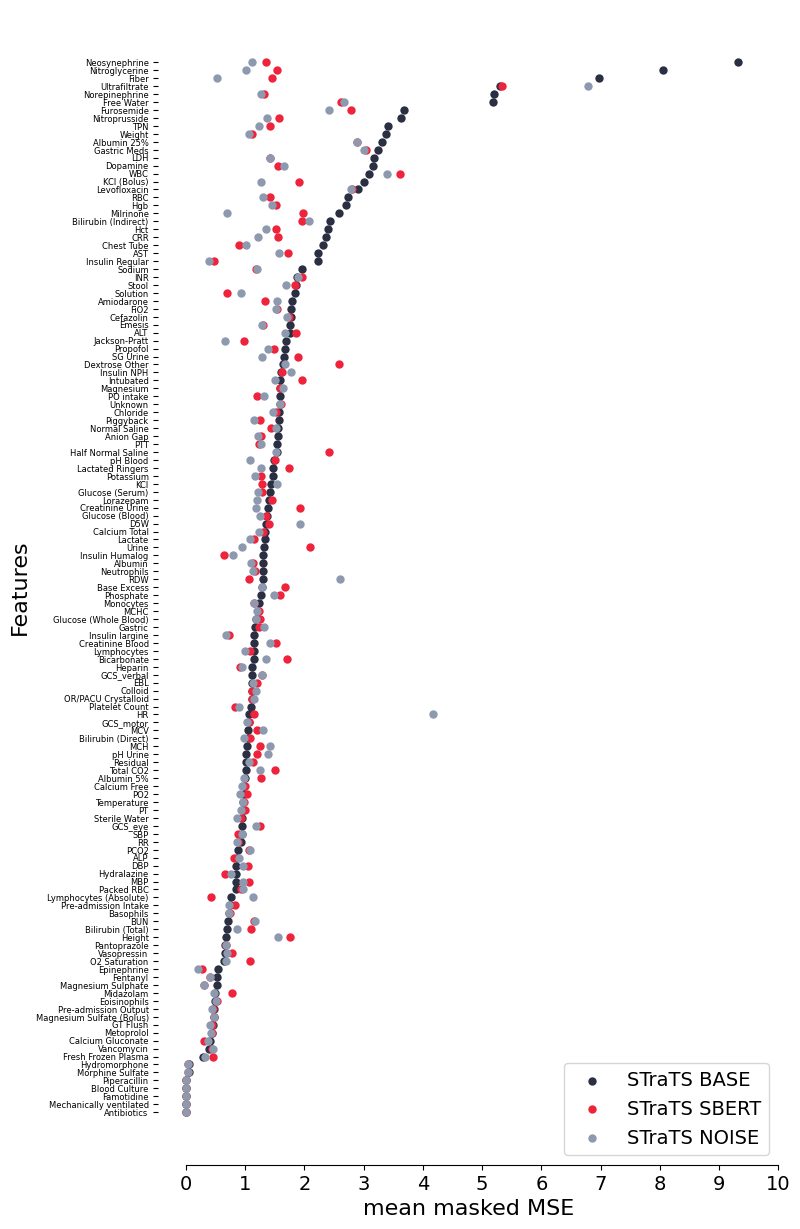

'fig = plt.figure(figsize=(12,8))\nfig.tight_layout()\ni, color = -1, [\'r\', \'m\', \'y\']\nfor frame in [only_laboratory_only_mse["notext"], only_laboratory_only_mse["sBert"], only_laboratory_only_mse["tfidf"]]:\n    i+=1\n    c = color[i]\n    plt.scatter(frame.values, frame.index, color=c)\n    #plt.plot(frame.values, frame.index, color=c)\n    #plt.plot(([frame.values.mean()]*len(notext_var_map)), frame.index, color=c) \n    \nplt.title("Average MSE of Lab Features ")\nplt.xlabel("MSE")\nplt.ylabel("Features")\nplt.legend([\'notext\',\'sBert\', \'tfidf\'],loc=\'upper right\')  \nplt.show'

In [121]:
## mse per feature, only laboratory
only_notext_variable_mse = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 0)
only_sb_variable_mse = mse_loss_with_nans(only_lab_sb,only_lab_notext_target, 0)
only_tf_variable_mse = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, 0)
print(only_tf_variable_mse)
only_laboratory_only_mse = pd.DataFrame({"notext": only_notext_variable_mse.values, "sBert": only_sb_variable_mse[:len(notext_var_map)].values, "tfidf": only_tf_variable_mse[:len(notext_var_map)].values}, index=notext_var_map)
only_laboratory_only_mse = only_laboratory_only_mse.sort_values(by=["notext"])
print("Average MSE of Lab Features")
print("wenn notext höher ist perfekt, wenn nicht fraglich wieso")
print(only_laboratory_only_mse.mean())

fig, ax = plt.subplots(
    figsize=(8, 15)
)
# Define font sizes
SIZE_SMALL = 6
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_SMALL)  # fontsize of the tick labels
"""# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean, notext_mean],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean, sb_mean],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean, tf_mean],
    label="STraTS TF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean,
    "STraTS TF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)"""
x = [0,1,2,3,4,5,6,7,8,9,10]
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE"]

for frame in [only_laboratory_only_mse["notext"], only_laboratory_only_mse["sBert"], only_laboratory_only_mse["tfidf"]]:
    ax.scatter(frame.values, frame.index, color=colors[i], label=labels[i], linewidth=0.01)
    """ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )"""
    #c = colors[i]
    #plt.plot(frame.index, frame['mse'], color=c)
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("mean masked MSE")
ax.set_ylabel("Features")
ax.tick_params(axis='y', labelsize=6)
#plt.xlim(0,18000)
#plt.ylim(0,30)
#plt.title("Average MSE from forecasting step 1 to 24")
#plt.xlabel("forecasting step")
#plt.ylabel("Average of MSE (over testset)")
ax.legend()
plt.savefig("EXPNOISE_featurewiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()



"""fig = plt.figure(figsize=(12,8))
fig.tight_layout()
i, color = -1, ['r', 'm', 'y']
for frame in [only_laboratory_only_mse["notext"], only_laboratory_only_mse["sBert"], only_laboratory_only_mse["tfidf"]]:
    i+=1
    c = color[i]
    plt.scatter(frame.values, frame.index, color=c)
    #plt.plot(frame.values, frame.index, color=c)
    #plt.plot(([frame.values.mean()]*len(notext_var_map)), frame.index, color=c) 
    
plt.title("Average MSE of Lab Features ")
plt.xlabel("MSE")
plt.ylabel("Features")
plt.legend(['notext','sBert', 'tfidf'],loc='upper right')  
plt.show"""

Your selected dataframe has 133 columns.
There are 133 columns that have missing values.


,Missing Values,% of Total Values
Lymphocytes (Absolute),176339,99.993
Insulin NPH,176299,99.970
Levofloxacin,176210,99.919
Residual,176195,99.911
Free Water,176107,99.861
...,...,...
MBP,13619,7.723
DBP,12851,7.287
SBP,12824,7.272
RR,11791,6.686


In [48]:
lab_missing

NameError: name 'lab_missing' is not defined

## below is deprecated

In [13]:
### MSE on Lab features vs MSE on LAB+SB, vs MSE on lab+TF -> Macht keinen sinn? weil wenn sB oder tf einfacher zu forecasten ists besser
print("STraTS-MSE on Testset, hours 5-28:",mse_loss_with_nans(notext_fo, notext_observe_targets, None))
print("SB-STraTS-MSE on Testset, hours 5-28:",mse_loss_with_nans(sb_fo,sb_observe_targets, None))
print("TF-STraTS-MSE on Testset, hours 5-28:",mse_loss_with_nans(tf_fo,tf_observe_targets, None))

STraTS-MSE on Testset, hours 5-28: 1.307107900848784
SB-STraTS-MSE on Testset, hours 5-28: 0.7621710323573437
TF-STraTS-MSE on Testset, hours 5-28: 0.9292691757127172


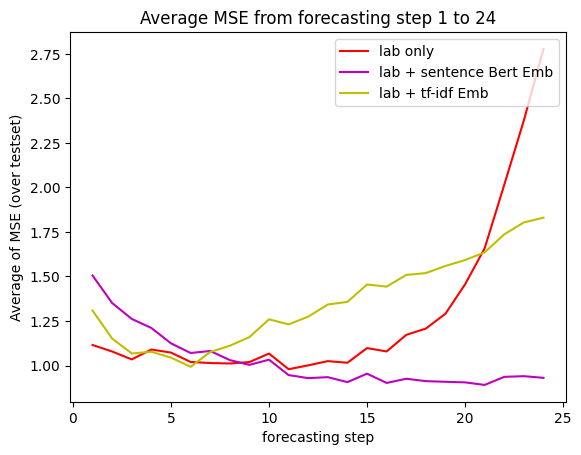

In [14]:
## COMPARE STEP WISE MSE OF LAB ONLY VS LAB+SB VS LAB+TF -> IF SB AND TF EASIER TO FORECAST AUTOMATICALLY LOWER MSE

notext_step_wise_mse_mean = notext_st.groupby("step").mean()
sb_step_wise_mse_mean = sb_st.groupby("step").mean()
tf_step_wise_mse_mean = tf_st.groupby("step").mean()

fig = plt.figure()
i, color = 0, ['r', 'm', 'y']
for frame in [notext_step_wise_mse_mean, sb_step_wise_mse_mean, tf_step_wise_mse_mean]:
    c = color[i]
    plt.plot(frame.index, frame['mse'], color=c)
    i+=1

#plt.xlim(0,18000)
#plt.ylim(0,30)
plt.title("Average MSE from forecasting step 1 to 24")
plt.xlabel("forecasting step")
plt.ylabel("Average of MSE (over testset)")
plt.legend(['lab only','lab + sentence Bert Emb', 'lab + tf-idf Emb'],loc='upper right')     
plt.show()


Still with grain of salt: This is first run of unseeded model, need atleast one more run of forecasts with unseeded model to compare. Then Seeded model, to get reproducible results.

Q: SBert seems to mitigate error accumulation, tf-idf increase it. Why could that be?

Q: Why is tfidf better than sentence Bert? 
Since I am using sentence Bert embeddings and tfidf vectors as INPUT FEATURES, as in, it is treated the same as MeanBP, Temperature etc, and as such also part of the forecast i obtain from strats here are some suspicions. 
Both SentenceBert Embeddings and TFIDF Vectors are representing semantics of text, thus, an accurate forecasting of these features introduces useful information. As far as i understand, the original BERT embeddings were not meant for semantic interpretation, and thus, in theory, it would not work.

Forecasting TF-IDF is essentially forecasting the occurence of important words, so words that play a big role in identifying the target.


--------------------

Fix numpy seed, masking muss rein, Reprpoducability!!!! d.h. ich muss herusfinden wie ich die imputed features remove!!! https://github.com/JINHXu/Early-Sepsis-Prediction-using-TSF/blob/main/data_prep_and_exploration/mimic_preprocessed_data_generation.py vlt ist das unser MIMIC-III mit text! DannText wieder preprocessen? Dann rerun training... sounds simple. MSE benutzen.

Why does stuff work? Sind tfidf und sbert embeddings semantic useful? Does it work? Control Experiments? Adde noise als alternative feature, was passiert? prob keine Zeit. Was könnten alternativen sein.

Für die 40 seiten muss ich ALLES was geht in Formeln bringen, sprich alle losses, PCA, sBert, tfidf, Fourier, feature averages, Model graph bzw bild.

Average MSE of Lab Features
notext    1.599566
sBert     1.260956
tfidf     1.229438
dtype: object


<function matplotlib.pyplot.show(close=None, block=None)>

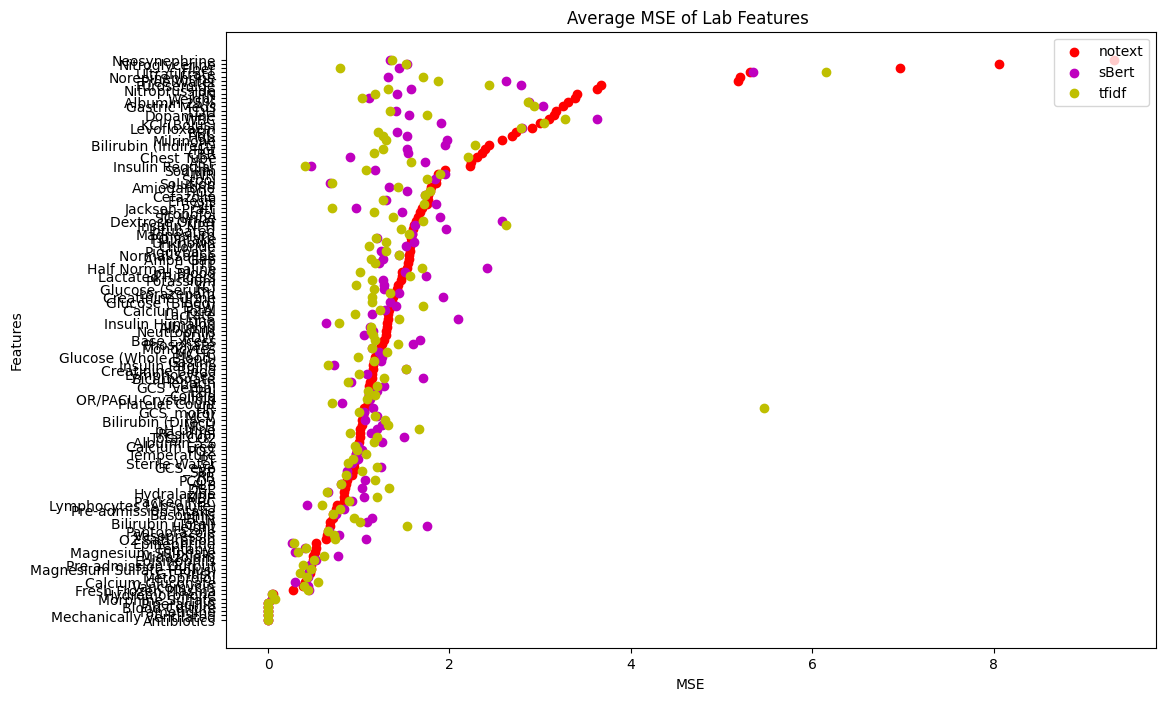

In [15]:

notext_variable_mse = mse_loss_with_nans(notext_fo, notext_observe_targets, 0)
sb_variable_mse = mse_loss_with_nans(sb_fo,sb_observe_targets, 0)
tf_variable_mse = mse_loss_with_nans(tf_fo,tf_observe_targets, 0)

laboratory_only_mse = pd.DataFrame({"notext": notext_variable_mse.values, "sBert": sb_variable_mse[:len(notext_var_map)].values, "tfidf": tf_variable_mse[:len(notext_var_map)].values}, index=notext_var_map)
laboratory_only_mse = laboratory_only_mse.sort_values(by=["notext"])
print("Average MSE of Lab Features")
print(laboratory_only_mse.mean())
fig = plt.figure(figsize=(12,8))
fig.tight_layout()
i, color = -1, ['r', 'm', 'y']
for frame in [laboratory_only_mse["notext"], laboratory_only_mse["sBert"], laboratory_only_mse["tfidf"]]:
    i+=1
    c = color[i]
    plt.scatter(frame.values, frame.index, color=c)
    #plt.plot(frame.values, frame.index, color=c)
    #plt.plot(([frame.values.mean()]*len(notext_var_map)), frame.index, color=c) 
    
plt.title("Average MSE of Lab Features ")
plt.xlabel("MSE")
plt.ylabel("Features")
plt.legend(['notext','sBert', 'tfidf'],loc='upper right')  
plt.show